>>> # Predicting Stocks using LSTM Model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

C:\Users\AAFathy\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


## Importing Data

In [2]:
ticker = 'MSFT'

In [3]:
start_date = dt.datetime(2017,1,1)
end_date = dt.datetime.now() - dt.timedelta(days=30)
print('From :',start_date,'To :', end_date)

From : 2017-01-01 00:00:00 To : 2025-03-25 12:02:45.697157


In [4]:
def load_ticker_data(ticker_symbol, start_date="2020-01-01", end_date=None, interval="1d"):
    """
    Load historical data for a given ticker from Yahoo Finance.

    Args:
        ticker_symbol (str): The stock ticker symbol (e.g., 'AAPL').
        start_date (str): The start date for the historical data (YYYY-MM-DD).
        end_date (str): The end date for the data. If None, fetches up to today.
        interval (str): Data interval ('1d', '1wk', '1mo', etc.).

    Returns:
        pandas.DataFrame: Historical price data for the ticker.
    """
    ticker = yf.Ticker(ticker_symbol)
    data = ticker.history(start=start_date, end=end_date, interval=interval)
    return data

In [7]:
data = load_ticker_data(ticker, start_date=start_date, end_date=end_date, interval='1d')

In [8]:
data = data.reset_index()
data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2017-01-03 00:00:00-05:00,56.791071,56.836293,56.194127,56.601135,20694100,0.0,0.0
1,2017-01-04 00:00:00-05:00,56.510665,56.754870,56.185059,56.347862,21340000,0.0,0.0
2,2017-01-05 00:00:00-05:00,56.248371,56.673468,56.103658,56.347862,24876000,0.0,0.0
3,2017-01-06 00:00:00-05:00,56.347883,57.116676,56.112725,56.836292,19922900,0.0,0.0
4,2017-01-09 00:00:00-05:00,56.763934,57.053364,56.564955,56.655399,20382700,0.0,0.0


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2068 entries, 0 to 2067
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype                           
---  ------        --------------  -----                           
 0   Date          2068 non-null   datetime64[ns, America/New_York]
 1   Open          2068 non-null   float64                         
 2   High          2068 non-null   float64                         
 3   Low           2068 non-null   float64                         
 4   Close         2068 non-null   float64                         
 5   Volume        2068 non-null   int64                           
 6   Dividends     2068 non-null   float64                         
 7   Stock Splits  2068 non-null   float64                         
dtypes: datetime64[ns, America/New_York](1), float64(6), int64(1)
memory usage: 129.4 KB


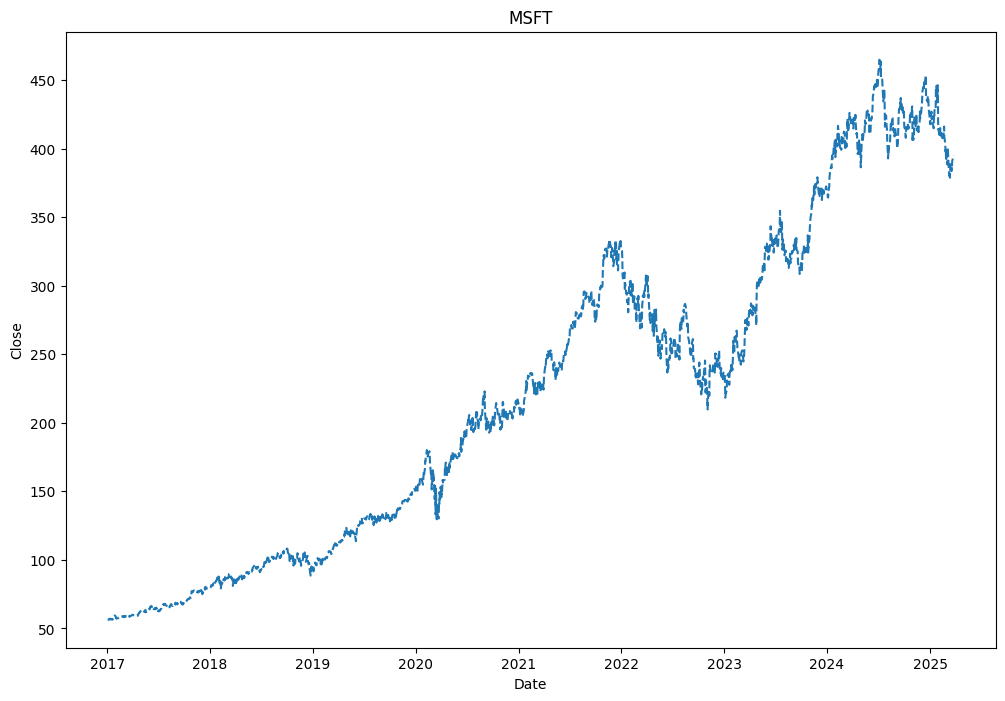

In [11]:
plt.figure(figsize=(12,8))
sns.lineplot(data=data,x='Date',y='Close',linestyle='--')
plt.title(f"{ticker}")
plt.show()

## Prepare Data for NN

In [12]:
#-- Normalization
mm_scaler = MinMaxScaler()
sd_scaler = StandardScaler()

In [13]:
data[['Close_scaled']] = sd_scaler.fit_transform(data[['Close']])

In [14]:
data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Close_scaled
0,2017-01-03 00:00:00-05:00,56.791071,56.836293,56.194127,56.601135,20694100,0.0,0.0,-1.396598
1,2017-01-04 00:00:00-05:00,56.510665,56.754870,56.185059,56.347862,21340000,0.0,0.0,-1.398749
2,2017-01-05 00:00:00-05:00,56.248371,56.673468,56.103658,56.347862,24876000,0.0,0.0,-1.398749
3,2017-01-06 00:00:00-05:00,56.347883,57.116676,56.112725,56.836292,19922900,0.0,0.0,-1.394602
4,2017-01-09 00:00:00-05:00,56.763934,57.053364,56.564955,56.655399,20382700,0.0,0.0,-1.396138


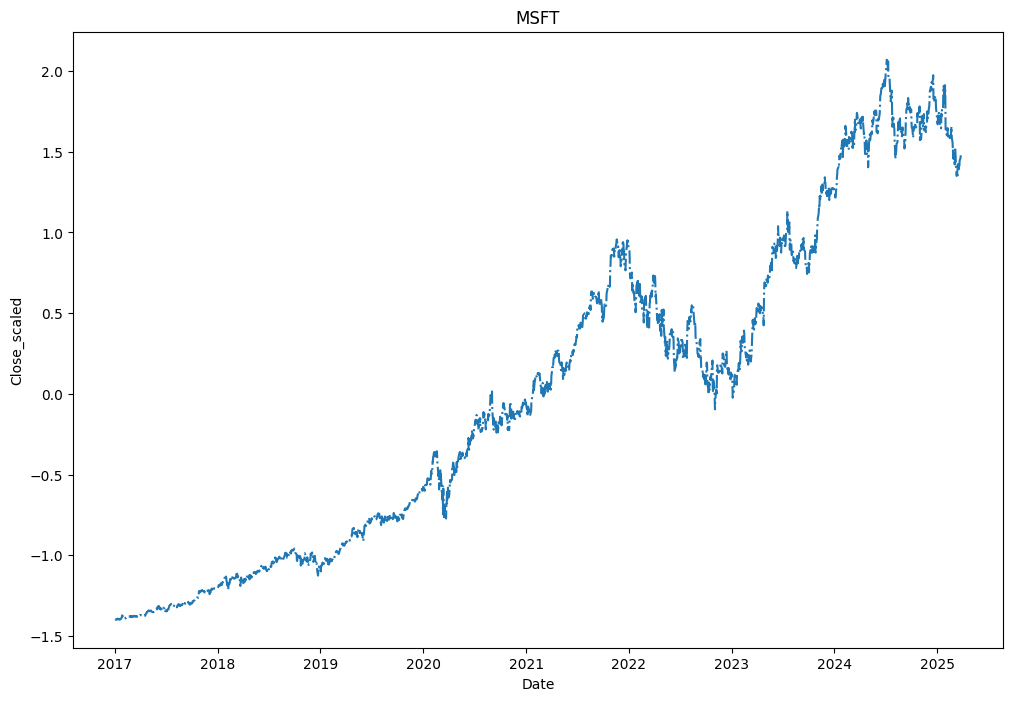

In [15]:
plt.figure(figsize=(12,8))
sns.lineplot(data=data,x='Date',y='Close_scaled',linestyle='-.')
plt.title(f"{ticker}")
plt.show()

In [16]:
scaled_close_prices = data['Close_scaled'].values.reshape(-1,1)
scaled_close_prices.shape

(2068, 1)

In [17]:
prediction_days=60
#x-train : 0-59 days, y_train : 1 day (60th day)

x_train, y_train = [], []

for x in range(prediction_days, len(scaled_close_prices)):
    x_train.append(scaled_close_prices[x-prediction_days:x,0])
    y_train.append(scaled_close_prices[x,0])

In [18]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_train_r = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
print(x_train_r.shape, y_train.shape)

(2008, 60, 1) (2008,)


## Model Building

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from tqdm import tqdm

In [186]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [545]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=96, dropout_rates=[0.3, 0.2, 0.1]):
        super(LSTMModel, self).__init__()
        self.hidden_size= hidden_size
        
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                             num_layers=1, batch_first=True)
        self.dropout1 = nn.Dropout(dropout_rates[0])
        
        self.lstm2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, 
                             num_layers=1, batch_first=True)
        self.dropout2 = nn.Dropout(dropout_rates[1])
        
        self.lstm3 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, 
                             num_layers=1, batch_first=True)
        self.dropout3 = nn.Dropout(dropout_rates[2])
        

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        
        h0 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        
        out, _ = self.lstm1(x, (h0, c0))
        out = self.dropout1(out)
        
        out, _ = self.lstm2(out)
        out = self.dropout2(out)
        
        out, _ = self.lstm3(out)
        out = self.dropout3(out[:, -1, :])

        out = self.fc(out)

        return out

# Initialize Clean Model
model = LSTMModel(hidden_size=96, dropout_rates=[0.3,0.2,0.1])

In [546]:
# Assume input shape is (batch_size=32, sequence_length=50, features=1)
summary(model, input_size=(32, 60, 1))

Layer (type:depth-idx)                   Output Shape              Param #
LSTMModel                                [32, 1]                   --
├─LSTM: 1-1                              [32, 60, 96]              38,016
├─Dropout: 1-2                           [32, 60, 96]              --
├─LSTM: 1-3                              [32, 60, 96]              74,496
├─Dropout: 1-4                           [32, 60, 96]              --
├─LSTM: 1-5                              [32, 60, 96]              74,496
├─Dropout: 1-6                           [32, 96]                  --
├─Linear: 1-7                            [32, 1]                   97
Total params: 187,105
Trainable params: 187,105
Non-trainable params: 0
Total mult-adds (M): 359.06
Input size (MB): 0.01
Forward/backward pass size (MB): 4.42
Params size (MB): 0.75
Estimated Total Size (MB): 5.18

In [540]:
# ==== CUSTOM DATA LOADING ====
def get_dataloaders_from_numpy(x_train_r, y_train, batch_size=64):
    x_tensor = torch.tensor(x_train_r, dtype=torch.float32)  # (n, 60 days, 1)
    y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # (n, 1)

    dataset = TensorDataset(x_tensor, y_tensor)
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return train_loader

In [531]:
# ==== TRAINING LOOP ====
def train(model, train_loader, epochs=20, lr=0.001, device='cuda'):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    last_loss = 0.0
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for x_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}, Loss {last_loss}"):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        last_loss = avg_loss
        #print(f"Epoch {epoch+1} Loss: {avg_loss:.4f}")

In [547]:
train_loader = get_dataloaders_from_numpy(x_train_r, y_train, batch_size=32)
train(model, train_loader, epochs=10, lr=0.0001, device=device)

Epoch 10/10, Loss 0.010064113375154279: 100%|█████████████████████████████████████████| 63/63 [00:00<00:00, 348.07it/s]


## Model Testing

In [337]:
def model_infer(model, input_starting_60_days, prediction_length=10, temperature=0.001, scaler=None, device='cpu'):
    model.eval()
    last_60_data = input_starting_60_days.copy()
    # add last day in given data
    predictions = [sd_scaler.inverse_transform(last_60_data[-1])[0]]

    for _ in range(prediction_length-1):
        # Prepare input tensor: shape (1, 60, 1)
        input_tensor = torch.tensor(last_60_data, dtype=torch.float32).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_tensor)  # shape (1, 1)
            output = output.cpu().numpy()  # convert to NumPy
            output += np.random.randn(1) * temperature  # add temperature to LSTM (mimic market uncertainity)

        predictions.append(sd_scaler.inverse_transform(output)[0][0])  # append scalar value
        last_60_data = np.vstack((last_60_data, output))[-60:]  # slide window

    return predictions

In [570]:
test_duration = 30
test_start =  dt.datetime.now() - dt.timedelta(days=test_duration)
test_end = dt.datetime.now()

test_data = load_ticker_data(ticker, start_date=test_start , end_date=test_end , interval='1d')
test_data = test_data.reset_index()

# get last
input_to_lstm_duration = 30
last_days_in_training = data.iloc[-input_to_lstm_duration:].copy()
scaled_close_prices_test = sd_scaler.transform(last_days_in_training['Close'].values.reshape(-1,1))

len(scaled_close_prices_test)

30

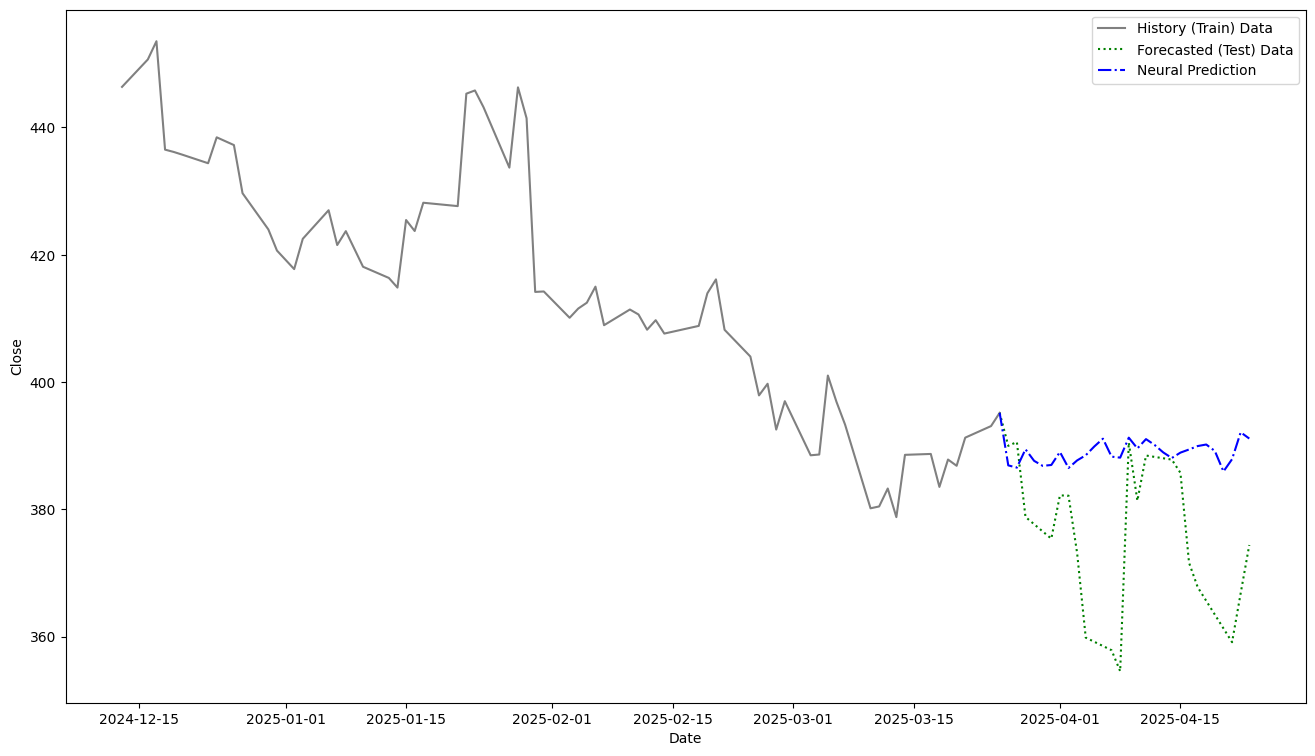

In [571]:
# Prepare starting sequence 
input_sequence = scaled_close_prices_test

# Inference
predictions = model_infer(model, input_sequence, prediction_length=test_duration, temperature=0.01, device=device)

predictions_ = np.array(predictions).squeeze()
predicted_dates = pd.date_range(start=data['Date'].iloc[-1], periods=len(predictions))
prediction_df = pd.DataFrame({'Date': predicted_dates, 'Predicted Close': predictions})

plt.figure(figsize=(16,9))

t_range = 2000
sns.lineplot(x=data.iloc[t_range:].Date,y= data.iloc[t_range:].Close,linestyle='-',color='gray', label='History (Train) Data')

sns.lineplot(x=test_data.Date,y= test_data.Close,linestyle=':',color='green', label='Forecasted (Test) Data')

sns.lineplot(x=prediction_df['Date'], y=prediction_df['Predicted Close'],linestyle='-.',color='blue', label='Neural Prediction')
plt.show()

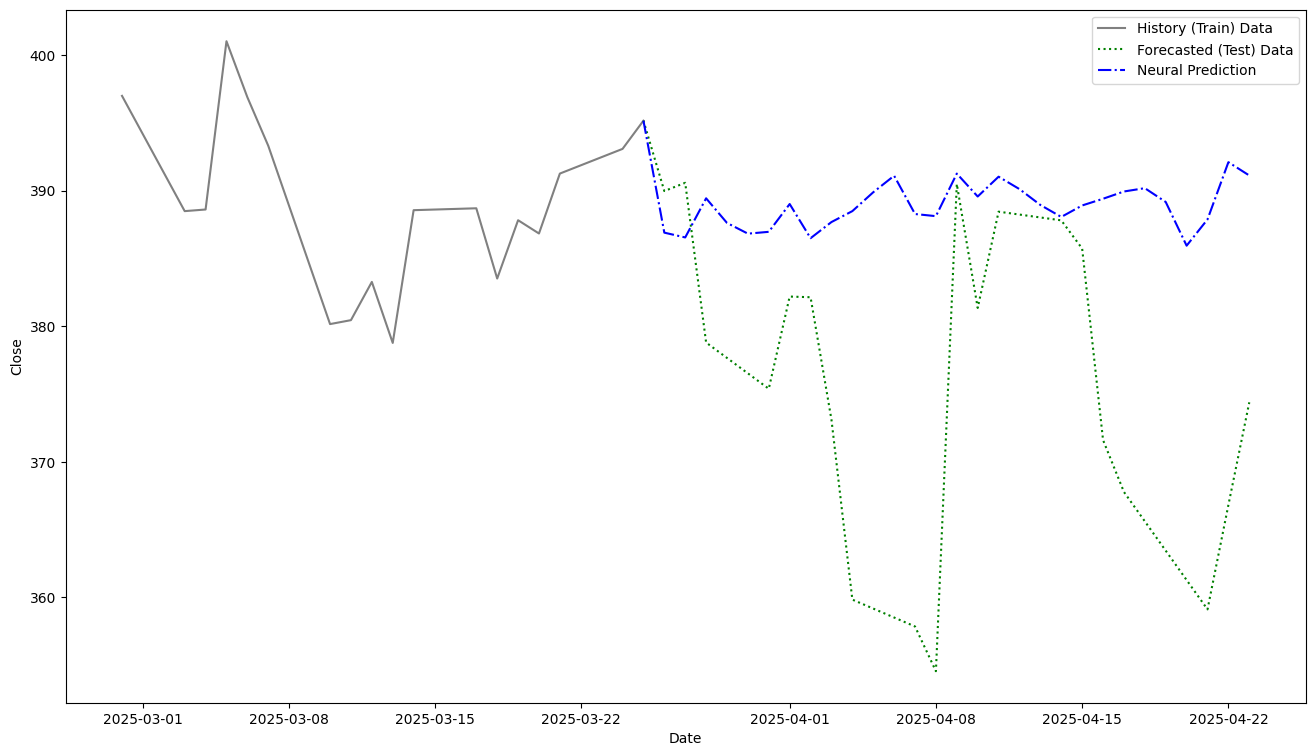

In [572]:
# Full figure
plt.figure(figsize=(16,9))

t_range = 2050
sns.lineplot(x=data.iloc[t_range:].Date,y= data.iloc[t_range:].Close,linestyle='-',color='gray', label='History (Train) Data')

sns.lineplot(x=test_data.Date,y= test_data.Close,linestyle=':',color='green', label='Forecasted (Test) Data')

sns.lineplot(x=prediction_df['Date'], y=prediction_df['Predicted Close'],linestyle='-.',color='blue', label='Neural Prediction')
plt.show()

## Summary & Improvements

* We used a relatively simple LSTM model, we can try increasing model capacity, different architectures and techniques.
* We didn't add any helpful data to our LSTM model like wether there is relevant news (Fundamental Analysis) or Indicator inputs (Technical Analysis)